<a href="https://colab.research.google.com/github/lokkyX3/Lending-Club-Analysis-Project/blob/main/Lending_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The EDA**

---

**Loading packages and data**

In [ ]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix


from google.colab import drive
drive.mount('/content/drive')

plt.style.use('seaborn')

In [52]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NN and DL Udemy/DATA/lending_club_loan_two.csv')

**What kind of features we had in this dataset?**

Note: For feature descriptions, please refer to Read Me.

In [ ]:
df.info(verbose=True, null_counts=True)

In [ ]:
df.describe().T

Since this is a classification problem, we should find out distribution of the label feature.

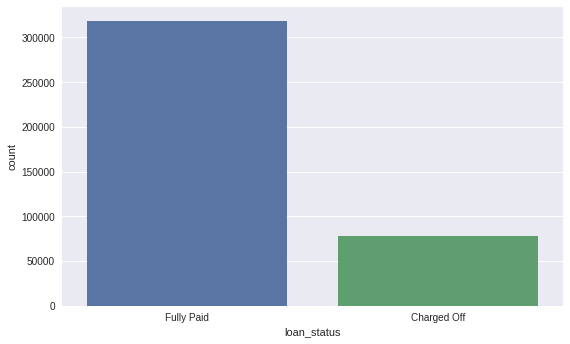

In [ ]:
sns.countplot(x='loan_status',data=df)

Note: This is a highly imbalanced dataset as there are alot more 'Fully Paid' than 'Charged Off' entries. Very similar situation with those of fraud and spam cases.

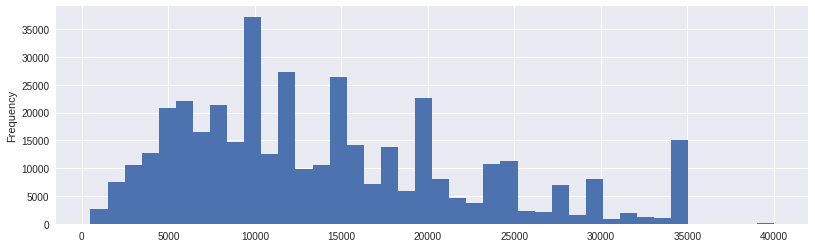

In [ ]:
plt.figure(figsize=(12, 4))
df['loan_amnt'].plot.hist(bins=40)

Note: Loan amount spike happening at even number. Which probably are the standard amount loans (e.g 10k, 15k, 20k...)

In [ ]:
sns.pairplot(df[['loan_amnt','int_rate','installment','loan_status']].sample(1000),hue='loan_status')

**Correlation**

Next, lets take a  look at the correlation between these continuous attributes

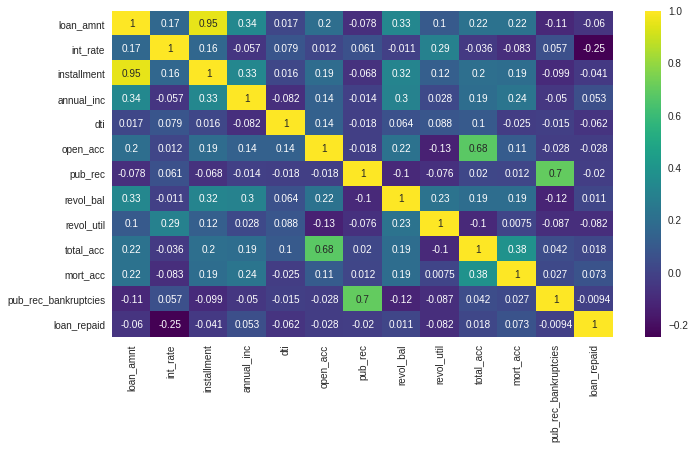

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(),annot=True,cmap='viridis')

Note: 'loan_amnt' and 'installment' had high correlation. A high correlation indicates the attributes are too similar to each other which might affect performance model. Let's plot it out

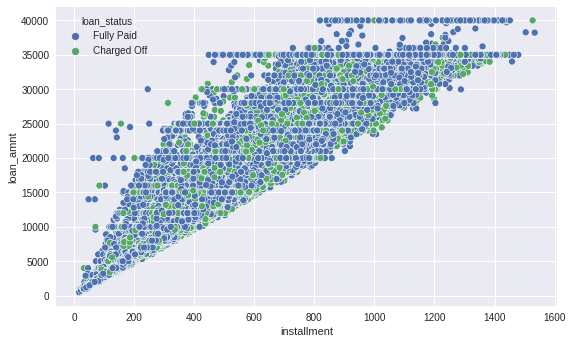

In [ ]:
sns.scatterplot(x='installment',y='loan_amnt',data=df,hue='loan_status')

They have a positive correlation where a higher loan will have a higher installment. This make sense as loan amount dictates the amount that had to be paid back monthly which is calculated based on certain formula. This explains the high correlation between this two attribute.  

**Questions: Is there any relationship between 'loan_status' and 'loan_amnt'? 
(eg. higher amount loan are more likely to charge off)**

loan_amnt                             ...                           
                count          mean          std  ...      50%      75%      max
loan_status                                       ...                           
Charged Off   77673.0  15126.300967  8505.090557  ...  14000.0  20000.0  40000.0
Fully Paid   318357.0  13866.878771  8302.319699  ...  12000.0  19225.0  40000.0

[2 rows x 8 columns]

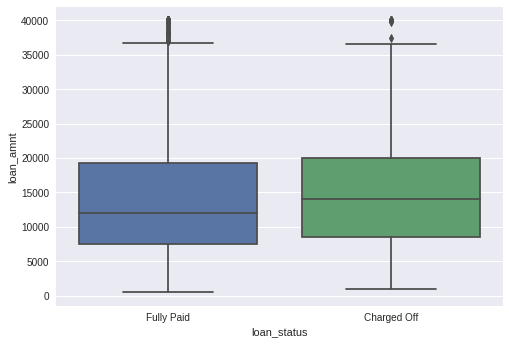

In [ ]:
sns.boxplot(x='loan_status',y='loan_amnt',data=df)
df[['loan_amnt','loan_status']].groupby('loan_status').describe()

Note: Hmmm! They are quite similar. Although on average, charged back category have slightly higher amount of loan compared to its counterpart.

**The Grades of Loan**
*  How about the grades of the loan?
*  Lower grades more likely to charged off?
*  Higher grade have higher rate of loan fully paid?











  

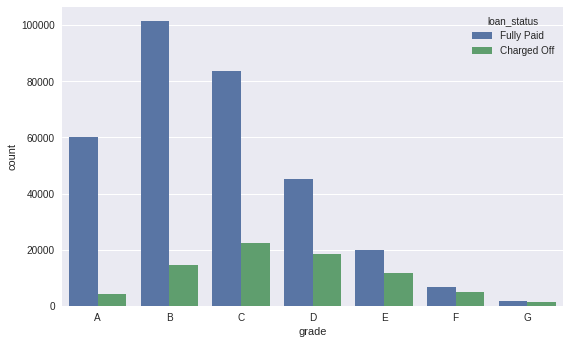

In [ ]:
sns.countplot(x='grade',hue='loan_status',data=df.sort_values(by='grade'))

In [ ]:
#@title
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "12pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "20pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '25pt')])]
            
df_bar=df[['loan_status','grade']].groupby('grade')['loan_status'].value_counts().reset_index(name='count')
df_bar.style.bar(subset='count').hide_index().highlight_max(subset='loan_status',color='#676967').set_table_styles(magnify())

grade,loan_status,count
A,Fully Paid,60151
A,Charged Off,4036
B,Fully Paid,101431
B,Charged Off,14587
C,Fully Paid,83538
C,Charged Off,22449
D,Fully Paid,45186
D,Charged Off,18338
E,Fully Paid,19723
E,Charged Off,11765


Note: Charged off loans exist across all grades. However, the 2 worst grade (F and G) had almost same rate for both category!

Let's dive further into these 2 grades!

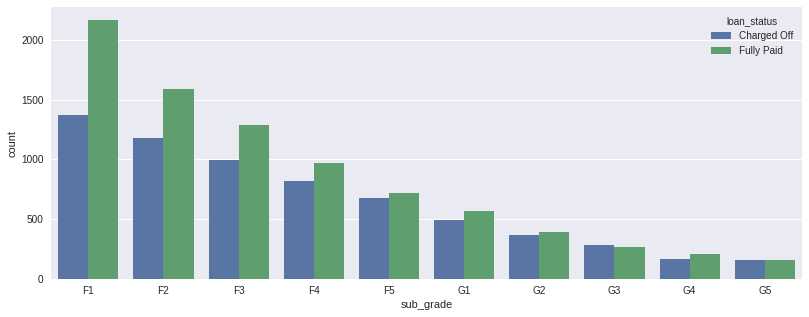

In [ ]:
#@title
plt.figure(figsize=(12,5))
sns.countplot(x='sub_grade',hue='loan_status',data=df[df.sub_grade.str.contains('F')|df.sub_grade.str.contains('G')].sort_values(by='sub_grade'))

Not suprisingly, decrease of the loan grade shows increase in the charge of rate. At G5, it's a coin flip whether the loan will be repaid.


# **Data Preprocessing**

---



In this section, we will decide which feature are important to keep and/or filling in the missing data

Since this is a classification problem, and the dataset will be fed into a NN. The string label will be mapped to 1 and 0 

(Fully paid = 1 and Charged Off = 0)

In [53]:
df['loan_repaid'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

In [ ]:
#@title
df[['loan_repaid','loan_status']].head(10)

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
5,1,Fully Paid
6,1,Fully Paid
7,1,Fully Paid
8,1,Fully Paid
9,1,Fully Paid


**The Missing Data**

Which attribute have missing data? And how many?

In [ ]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [ ]:
(df.isnull().sum()/len(df)) * 100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

There are a few number of features with missin data. Some of them are of insignificant amount which has less than 1%. We should explore more on the features that had large amount of missing data.


**Employment title and Employment length**

Drop or keep?

Employment Title

First, it useful to find out what kind of unique value we had in emp_title.

In [ ]:
df.emp_title.value_counts()

Teacher                         4389
Manager                         4250
Registered Nurse                1856
RN                              1846
Supervisor                      1830
                                ... 
Topline Home Healthcare            1
Opt Tech                           1
Director I/S                       1
Care manager                       1
Chief, Real  Estate Division       1
Name: emp_title, Length: 173105, dtype: int64

There are too many unique value in this attribute. Converting it with one-hot encoding is impossible. 

emp_title can be removed

In [54]:
df.drop(['emp_title'],axis=1,inplace=True)

Employment Length

What about employment length?

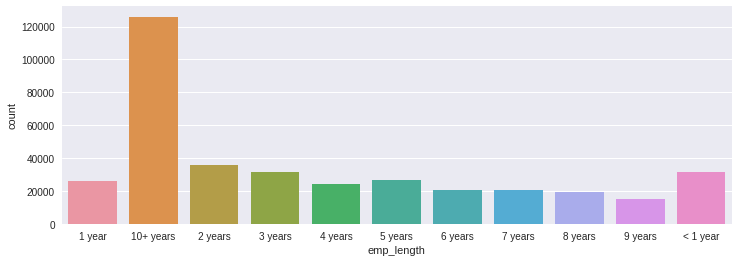

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(x='emp_length',data=df.sort_values(by='emp_length'))

Note: Most of the borrower are with more than 10 years of employment.

Next, we would like to see fully paid and charged off category betweens employment length.

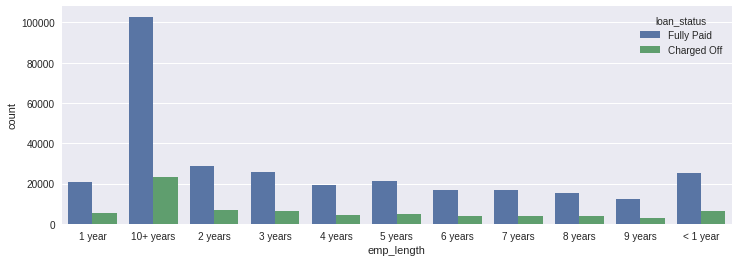

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(x='emp_length',hue='loan_status',data=df.sort_values(by='emp_length'))

This still doesnt tell us whether employment length is an important feature. It doesnt show a strong relationship between employment length and being charged off.

A better way to do this, is to find the percentage of charged off for each category of employment length.

In [ ]:
percentage_co = df[df['loan_status']=='Charged Off'].emp_length.value_counts() / df.emp_length.value_counts()

1 year       0.199135
10+ years    0.184186
2 years      0.193262
3 years      0.195231
4 years      0.192385
5 years      0.192187
6 years      0.189194
7 years      0.194774
8 years      0.199760
9 years      0.200470
< 1 year     0.206872
Name: emp_length, dtype: float64

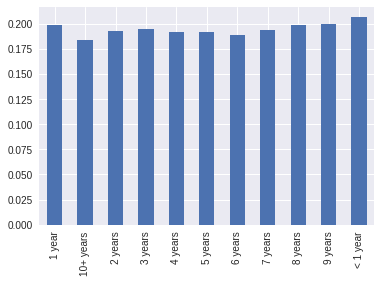

In [ ]:
#@title
percentage_co.plot(x='emp_length',kind='bar')
percentage_co

We can see that percentage of charged off for each category are kinda similar. This tell us that employment length is not a good attribute that distinguish between charged off and fully paid. DROP IT!

In [55]:
df.drop(['emp_length'],axis=1,inplace=True)

**Title**

Looking at the attribute description:

>        title	The loan title provided by the borrower

>       purpose	A category provided by the borrower for the loan request.







In [ ]:
df['title']

In [ ]:
df['title'].head(10)

0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
5         Debt consolidation
6           Home improvement
7       No More Credit Cards
8         Debt consolidation
9         Debt Consolidation
Name: title, dtype: object

In [ ]:
df['purpose'].head(10)

0              vacation
1    debt_consolidation
2           credit_card
3           credit_card
4           credit_card
5    debt_consolidation
6      home_improvement
7           credit_card
8    debt_consolidation
9    debt_consolidation
Name: purpose, dtype: object

Note: It seems title is just a subcategory for purpose. They held very similar information.

In [56]:
df.drop(['title'],axis=1,inplace=True)

Impute mort_acc

KNN-Impute: Take too long

In [ ]:
# imputer = KNNImputer(n_neighbors=2)
# mort = imputer.fit_transform(df[['mort_acc','total_acc']])

Lets find which attribute is highly correlated with mort_acc

In [ ]:
df.corr().mort_acc

loan_amnt               0.222315
int_rate               -0.082583
installment             0.193694
annual_inc              0.236320
dti                    -0.025439
open_acc                0.109205
pub_rec                 0.011552
revol_bal               0.194925
revol_util              0.007514
total_acc               0.381072
mort_acc                1.000000
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
Name: mort_acc, dtype: float64

Note: total_acc seems to havve a high correltion with mort_acc. Since mort_acc has a strong correlation with total_acc we will group the dataframe by the total_acc and calculate the mean value for the mort_acc per total_acc entry.

In [57]:
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']
print(total_acc_avg)

total_acc
2.0      0.000000
3.0      0.052023
4.0      0.066743
5.0      0.103289
6.0      0.151293
           ...   
124.0    1.000000
129.0    1.000000
135.0    3.000000
150.0    2.000000
151.0    0.000000
Name: mort_acc, Length: 118, dtype: float64


In [30]:
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [58]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [59]:
df.dropna(subset=['revol_util','pub_rec_bankruptcies'],inplace=True)

In [ ]:
df.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
dtype: int64

Categorical variables and dummy variables

In [ ]:
list(df.select_dtypes(include='object'))

['term',
 'grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'address']

**Term**

In [12]:
df['term']

0          36 months
1          36 months
2          36 months
3          36 months
4          60 months
             ...    
396025     60 months
396026     36 months
396027     36 months
396028     60 months
396029     36 months
Name: term, Length: 395219, dtype: object

Now lets convert term feature to int type (36 or 60)

In [60]:
df['term'] = df['term'].apply(lambda term: int(term[:3]))
df['term']

0         36
1         36
2         36
3         36
4         60
          ..
396025    60
396026    36
396027    36
396028    60
396029    36
Name: term, Length: 395219, dtype: int64

**Grade and Sub-grade**

We already know grade is part of sub_grade, so just drop the grade feature.

In [61]:
df.drop('grade',axis=1,inplace=True)

Converting sub grades to dummy variables

In [62]:
subgrade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)
df.drop('sub_grade',axis=1,inplace=True)

In [63]:
df = pd.concat([df,subgrade_dummies],axis=1)

In [64]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address',
       'loan_repaid', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5',
       'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4',
       'G5'],
      dtype='object')

Home ownership

In [44]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

The majority of the home ownership are under mortage, rent and own. Since the bottom 3 are significantly less, we can just group them together under a categry to reduce the number of feature.

In [65]:
df['home_ownership'] = df['home_ownership'].replace(['NONE','ANY'],'OTHER')

In [66]:
home_dummies = pd.get_dummies(data=df['home_ownership'])

In [67]:
df.drop('home_ownership',axis=1,inplace=True)

In [68]:
df = pd.concat([df,home_dummies],axis=1)

In [69]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'address', 'loan_repaid', 'A2', 'A3', 'A4',
       'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1',
       'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3',
       'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT'],
      dtype='object')

Address and Zipcode

Adress might be too granular. However, using zipcode might be useful. We can extract zipcode from the address feature.

In [75]:
df['zip_code'] = df['address'].apply(lambda address:address[-5:])

Converting zip code into dummy variable

In [78]:
zip_dummies = pd.get_dummies(data=df['zip_code'])

In [79]:
df.drop(['zip_code','address'],axis=1,inplace=True)

In [80]:
df = pd.concat([df,zip_dummies],axis=1)

issue_d

We wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, drop this feature.

In [82]:
df.drop('issue_d',axis=1,inplace=True)

earliest_cr_line

This appears to be a historical time stamp feature. Lets extract the year from this feature and convert it to int type.

In [83]:
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda x: int(x[-4:]))

In [84]:
df.drop('earliest_cr_line',axis=1,inplace=True)

verification_status, application_type,initial_list_status,purpose

Let's convert these columns into dummy variables and concatenate them with the original dataframe.

In [70]:
dummies_var = pd.get_dummies(data=df[['verification_status', 'application_type','initial_list_status','purpose']], drop_first=True)

In [71]:
df.drop( ['verification_status', 'application_type','initial_list_status','purpose'],axis=1,inplace=True)

In [72]:
df = pd.concat([df,dummies_var],axis=1)

# Train Test Split

Drop the load_status column we created earlier, since its a duplicate of the loan_repaid column. We'll use the loan_repaid column since its already in 0s and 1s.

In [89]:
df.drop('loan_status',axis=1,inplace=True)

In [90]:
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values

Now, we split the data into training and testing set

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

# Normalizing the Data

**TASK: Use a MinMaxScaler to normalize the feature data X_train and X_test. Recall we don't want data leakge from the test set so we only fit on the X_train data.**

In [99]:
scaler = MinMaxScaler()

In [100]:
X_train = scaler.fit_transform(X_train)

In [101]:
X_test = scaler.transform(X_test)

# Creating the Model


In [102]:

model = Sequential()

#input layer
model.add(Dense(units=78,activation='relu'))
model.add(Dropout(0.2))

#hidden layer
model.add(Dense(units=39,activation='relu'))
model.add(Dropout(0.2))

#hidden layer
model.add(Dense(units=19,activation='relu'))
model.add(Dropout(0.2))

#output layer
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

Early stoppage

Early stoppage enable us to stop the training when the model stop to improve for a certain epoch.

In [94]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [103]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/25
9263/9263 [==============================] - 18s 2ms/step - loss: 0.2959 - val_loss: 0.2622
Epoch 2/25
9263/9263 [==============================] - 17s 2ms/step - loss: 0.2617 - val_loss: 0.2613
Epoch 3/25
9263/9263 [==============================] - 17s 2ms/step - loss: 0.2616 - val_loss: 0.2615
Epoch 4/25
9263/9263 [==============================] - 17s 2ms/step - loss: 0.2602 - val_loss: 0.2616
Epoch 5/25
9263/9263 [==============================] - 17s 2ms/step - loss: 0.2613 - val_loss: 0.2608
Epoch 6/25
9263/9263 [==============================] - 17s 2ms/step - loss: 0.2606 - val_loss: 0.2605
Epoch 7/25
9263/9263 [==============================] - 17s 2ms/step - loss: 0.2595 - val_loss: 0.2603
Epoch 8/25
9263/9263 [==============================] - 17s 2ms/step - loss: 0.2600 - val_loss: 0.2609
Epoch 9/25
9263/9263 [==============================] - 17s 2ms/step - loss: 0.2611 - val_loss: 0.2611
Epoch 10/25
9263/9263 [==============================] - 17s 2ms/step - l

In [104]:
model_loss = pd.DataFrame(model.history.history)

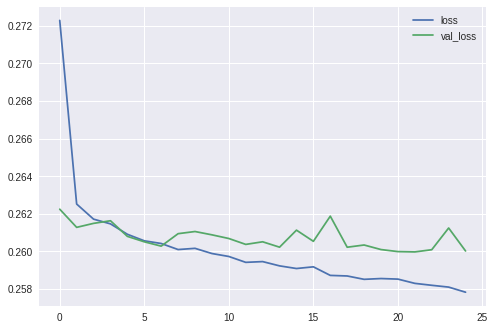

In [105]:
model_loss.plot()

Note: The training loss and validation loss decreases untill no  much improvement are observed.

Next, let's look at the confusion matrix for this model.

In [ ]:
predictions = model.predict_classes(X_test)

In [108]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.46      0.62     19355
           1       0.88      0.99      0.93     79450

    accuracy                           0.89     98805
   macro avg       0.91      0.73      0.78     98805
weighted avg       0.89      0.89      0.87     98805



In [110]:
confusion_matrix(y_test,predictions)

array([[ 8904, 10451],
       [  559, 78891]])

* Our model seems to predicts correctly with a accuracy of 0.89

* This tally to what we had know. The dataset comprise of ~0.8 of fully paid loan entries. So, the performance of this models reflects that.

* However, the performance for class 0 is kind of low when compare to class 1

* This is due to the nature of unbalanced class dataset.

Improvement to explore:
* No. of NN layers
* Dropout parameter


